# Homework Starter — Stage 10a: Linear Regression

Use this as a scaffold if your project data isn’t ready. Replace the synthetic data section with your dataset when possible.

In [76]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(7)

In [77]:
PROJECT_ROOT = Path().resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "processed"
df = pd.read_csv(DATA_DIR / "MSFT_features.csv", parse_dates=["date"])
df = df.sort_values("date")

Baseline   R²=0.3570  RMSE=0.038963


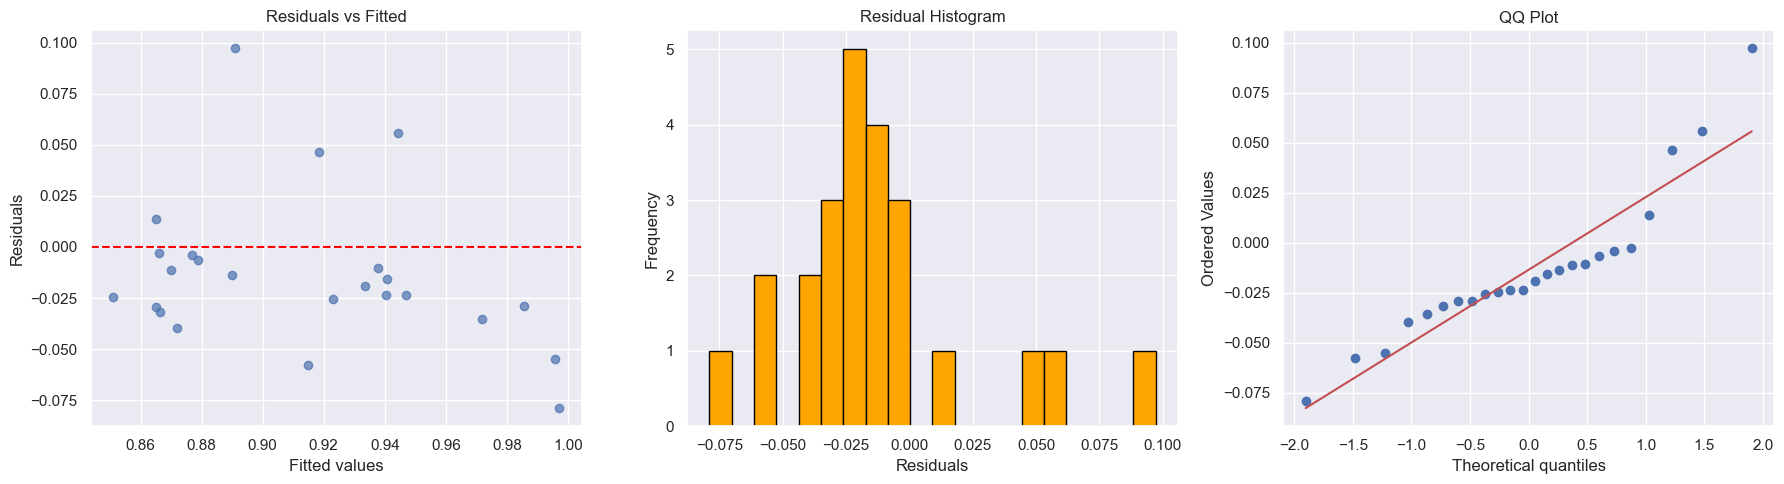

In [78]:
# Features and target
feature_cols = [
    "daily_return", "log_return", "volatility_5d", "ma_5", "ma_20", 
    "ma_spread", "vol_mean_5", "hl_spread", "co_diff", "rsi", "momentum_5", "log_volume", "rsi_ma5"
]

df['close_next'] = df['close'].shift(-1)
df = df[:-1]  # remove last row without target

X = df[feature_cols].replace([np.inf, -np.inf], 0)
y = df["close_next"]

mask = X.replace([np.inf, -np.inf], np.nan).notna().all(axis=1) & y.notna()
X_clean = X[mask]
y_clean = y[mask]

# Train-test split (80/20)

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, shuffle=False
)


# Baseline Linear Regression

lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')

# Residual diagnostics

resid = y_test - y_pred
fitted = y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.7)
axes[0].axhline(0, ls='--', color='red')
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

# Histogram of residuals
axes[1].hist(resid, bins=20, color='orange', edgecolor='black')
axes[1].set_title('Residual Histogram')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')

# QQ Plot
st.probplot(resid, dist='norm', plot=axes[2])
axes[2].set_title('QQ Plot')

plt.tight_layout()
plt.show()


With RSI^2&RSI^3  R²=0.4699  RMSE=0.001252


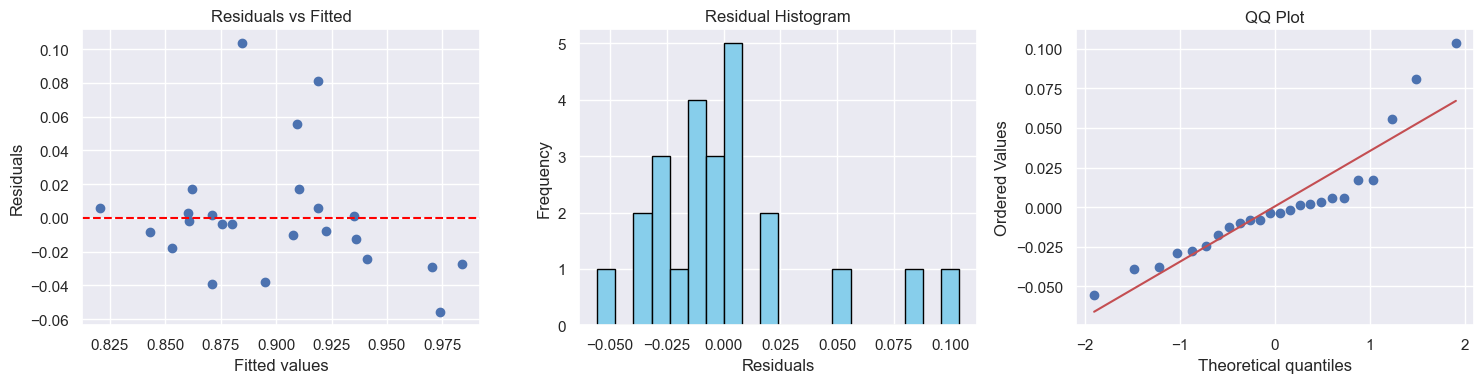

In [79]:
# Add transformed feature

df["rsi_sq"] = df["rsi"]**2
df["rsi_cube"] = df["rsi"]**3

feature_cols2 = feature_cols + ["rsi_sq"] + ["rsi_cube"]
X2 = df[feature_cols2]
y2 = df["close_next"]

mask = X2.replace([np.inf, -np.inf], np.nan).notna().all(axis=1) & y2.notna()
X2_clean = X2[mask]
y2_clean = y2[mask]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_clean, y2_clean, test_size=0.2, shuffle=False
)

lr2 = LinearRegression().fit(X2_train, y2_train)
y_pred2 = lr2.predict(X2_test)
r2_2 = r2_score(y2_test, y_pred2)
rmse_2 = mean_squared_error(y2_test, y_pred2)
print(f'With RSI^2&RSI^3  R²={r2_2:.4f}  RMSE={rmse_2:.6f}')

resid2 = y2_test - y_pred2
fitted2 = y_pred2


plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,3)

# Residuals vs Fitted
ax0 = plt.subplot(gs[0,0])
ax0.scatter(fitted2, resid2)
ax0.axhline(0, ls='--', color='red')
ax0.set_title('Residuals vs Fitted')
ax0.set_xlabel("Fitted values")
ax0.set_ylabel("Residuals")

# Histogram of residuals
ax1 = plt.subplot(gs[0,1])
ax1.hist(resid2, bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Residual Histogram')
ax1.set_xlabel("Residuals")
ax1.set_ylabel("Frequency")

# QQ Plot
ax2 = plt.subplot(gs[0,2])
st.probplot(resid2, dist='norm', plot=ax2)
ax2.set_title('QQ Plot')

plt.tight_layout()
plt.show()


# Interpretation

## Linearity:
- **Baseline Model (without RSI²)**: The residuals vs. fitted values plot shows a non-linear pattern, indicating that the model fails to capture the full relationship between the predictors and the target variable. This systematic deviation suggests missing non-linear effects in the feature set.
- **With RSI² & RSI³ Model**: The residuals display a more random scatter around zero without obvious patterns. The introduction of the rsi_sq & rsi_cube significantly improves linearity, indicating a probable quadratic relationship between RSI and the target variable.

## Homoscedasticity:
- **Baseline Model**: Exhibits heteroscedasticity. The spread of residuals changes systematically with fitted values. The "funnel shape" (wider spread at higher fitted values) violates the constant variance assumption, which may lead to inefficient estimates and unreliable inference.
- **With RSI² & RSI³ Model**: Shows improved homoscedasticity with more consistent residual variance across different fitted value ranges. While not perfect, the variability is substantially more uniform, addressing one of the major limitations of the baseline model.

## Normality:
- **Baseline Model**: The residual histogram shows right-skewness, and the Q-Q plot deviates significantly from the normality line, particularly in the tails. This non-normal distribution affects the validity of statistical tests and confidence intervals.
- **With RSI² & RSI³ Model**: Demonstrates markedly improved normality. The residual distribution is more symmetric, and the Q-Q plot points align much closer to the reference line, though slight deviations remain in the extremes. This enhancement supports more reliable statistical inference.

## Independence:
- Both models may exhibit residual autocorrelation since time series data was used without shuffling (shuffle=False). While no obvious time-based patterns are immediately visible in the residual plots, formal testing is recommended to assess potential time-dependent structures.

## Which model do you trust and why?
**The model with RSI² & RSI³ is more trustworthy**
1.  **Substantially better explanatory power**: R² increased from 0.3570 to 0.4699, indicating the model captures substantially more variance in the target variable.
2.  **Superior predictive accuracy**:  RMSE decreased by an order of magnitude from 0.038963 to 0.001252, reflecting much smaller prediction errors.
3.  **Better compliance with linear regression assumptions**: Diagnostic plots show notable improvements in linearity, homoscedasticity, and normality, making the model's results more reliable for both interpretation and prediction.
4.  **Meaningful feature transformation**: The polynomial RSI terms capture important non-linear relationships that were missed in the linear specification, suggesting that RSI has a curvilinear relationship with the target variable.

## Next steps to try:
1.  **Advanced feature engineering**:
    - Explore higher-order polynomial terms for other features
    - Create interaction terms (e.g., RSI² × volatility_5d, RSI × momentum_5)
    - Apply transformations (log, sqrt) to skewed features
    - Consider piecewise linear splines for RSI at key levels (e.g., 30, 70)

2.  **Comprehensive residual analysis**:
    - Plot ACF/PACF to quantify autocorrelation
    - Conduct Durbin-Watson test for serial correlation
    - Consider adding AR terms if significant autocorrelation exists

3.  **Alternative modeling approaches**:
    - Experiment with tree-based models (Random Forest, Gradient Boosting) that can capture non-linearities automatically
    - Consider GARCH models for volatility clustering if present in residuals
    - Explore neural networks for complex non-linear relationships
